# 数据挖掘-预测贷款用户是否逾期
## Task6：模型融合（2天）

------
### 1&emsp;划分数据集

 - 导入宏包

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['font.sans-serif']=[u'SimHei']
mpl.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.float_format',lambda x : '%.5f' % x)

 - 导入数据

In [2]:
data = pd.read_csv('./data/data_clean.csv', encoding='gbk')
Y = data['status']
X = data.drop(['status'], axis=1)

 - 归一化

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

 - 划分数据集

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)

 - SMOTE 上采样

In [5]:
from imblearn.over_sampling import SMOTE
x_train_smote, y_train_smote = SMOTE(random_state=2018).fit_sample(x_train, y_train)

Using TensorFlow backend.


-------
### 2&emsp;模型融合

&emsp;模型融合采用 Stacking 方法

&emsp;依据 Task5 提取 XGBClassifier、LGBMClassifier、RFClassifier 作为基模型

&emsp;采用 LogisticRegressionCV 作为次模型

#### 2.1 模型调参

&emsp;现对所有基模型进行调超参优化

 - XGBClassifier

In [6]:
from xgboost import XGBClassifier
parameters = {'max_depth': [3, 4, 5, 6, 7, 8],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'learning_rate': [0.01, 0.1, 0.2],
              'min_child_weight': [1, 2, 3],
              }
n_iter_search = 20
RS = RandomizedSearchCV(XGBClassifier(random_state=2018), parameters, n_iter=n_iter_search, cv=5, iid=False, scoring='roc_auc')
RS.fit(x_train_smote, y_train_smote)

XGB=RS.best_estimator_
print('Test set score: {:.3f}'.format(RS.score(x_test,y_test)))

Test set score: 0.771


 - LGBMClassifier

In [7]:
from lightgbm import LGBMClassifier
parameters = {'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35],
              }
n_iter_search = 20
RS = RandomizedSearchCV(LGBMClassifier(random_state=2018), parameters, n_iter=n_iter_search, cv=5, iid=False, scoring='roc_auc')
RS.fit(x_train_smote, y_train_smote)

LGBM = RS.best_estimator_
print('Test set score: {:.3f}'.format(RS.score(x_test,y_test)))

Test set score: 0.784


 - RFClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth': [3, 4, 5, 6, 7],
              'max_features': sp_randint(1, 11),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']
              }
n_iter_search = 20
RS = RandomizedSearchCV(RandomForestClassifier(random_state=2018), parameters, n_iter=n_iter_search, cv=5, iid=False, scoring='roc_auc')
RS.fit(x_train_smote, y_train_smote)
RF = RS.best_estimator_
print('Test set score: {:.3f}'.format(RS.score(x_test,y_test)))

Test set score: 0.781


 - LogisticRegressionCV

In [9]:
from sklearn.linear_model import LogisticRegressionCV
LR = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000)

#### 2.2 模型融合

 - Stacking

In [10]:
from mlxtend.classifier import StackingClassifier
StackingModel = StackingClassifier(classifiers=[XGB, LGBM, RF],
                                        use_probas=True, 
                                        average_probas=False,
                                        meta_classifier=LR,
                                       )

 - 模型评价

生成评价指标函数

In [11]:
from sklearn import metrics
def Eva(clf, x_test, y_test):
    y_predic = clf.predict(x_test)
    y_proba = clf.predict_proba(x_test)

    acc = metrics.accuracy_score(y_test, y_predic)
    p = metrics.precision_score(y_test, y_predic)
    r = metrics.recall_score(y_test, y_predic)
    f1 = metrics.f1_score(y_test, y_predic)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

生成绘图函数

In [12]:
def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw, label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.show()

 - 模型结果

  Model dataset  Accuracy  Precision  Recall  F1 score     AUC
0    LR   train   0.76453    0.51643 0.71990   0.60142 0.82224
1    LR    test   0.72570    0.48380 0.64183   0.55172 0.76500
2    RF   train   0.86693    0.73280 0.72513   0.72895 0.92203
3    RF    test   0.76262    0.55152 0.52149   0.53608 0.78144
4   XGB   train   0.99968    1.00000 0.99869   0.99935 1.00000
5   XGB    test   0.77769    0.61638 0.40974   0.49225 0.77104
6  LGBM   train   0.97222    0.97346 0.91230   0.94189 0.99628
7  LGBM    test   0.78146    0.61943 0.43840   0.51342 0.78443
8    SM   train   1.00000    1.00000 1.00000   1.00000 1.00000
9    SM    test   0.76639    0.57414 0.43266   0.49346 0.71603


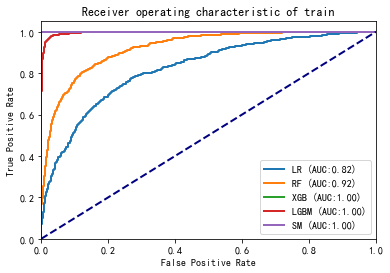

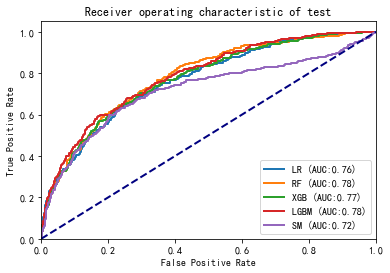

In [13]:
models = {'LR': LR,
          'RF': RF,
          'XGB': XGB,
          'LGBM': LGBM,
          'SM': StackingModel}

df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []

for name, clf in models.items():
    clf.fit(x_train_smote, y_train_smote)
    acc, p, r, f1, fpr_train, tpr_train, auc_train = Eva(clf, x_train, y_train)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    aucs_train.append(auc_train)
    df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
    row += 1

    acc, p, r, f1, fpr_test, tpr_test, auc_test = Eva(clf, x_test, y_test)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    aucs_test.append(auc_test)
    df_result.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
    row += 1

print(df_result)

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')